In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline 

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, log_loss, roc_auc_score, roc_curve, RocCurveDisplay

In [2]:
xl_df= pd.read_excel('../datasets/liver_data_with_metadata.xlsx')

In [3]:
xl_df.isna().sum()/len(xl_df)

Age of the patient                      0.000065
Gender of the patient                   0.029390
Total Bilirubin                         0.021114
Direct Bilirubin                        0.018279
 Alkphos Alkaline Phosphotase           0.025936
 Sgpt Alamine Aminotransferase          0.017530
Sgot Aspartate Aminotransferase         0.015053
Total Protiens                          0.015086
 ALB Albumin                            0.016096
A/G Ratio Albumin and Globulin Ratio    0.018214
Result                                  0.000000
dtype: float64

In [4]:
xl_df.drop_duplicates(inplace=True)

In [5]:
xl_df.describe()

,Age of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result
count,19367.000000,18811.000000,18878.000000,18674.000000,18909.000000,18975.000000,18998.000000,18955.000000,18932.000000,19368.000000
mean,43.809986,3.315767,1.515637,289.407411,80.598762,110.790672,6.494326,3.141045,0.945888,1.286917
std,16.454988,6.111851,2.863609,239.727272,181.134634,278.927937,1.089985,0.793602,0.322023,0.452334
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,32.000000,0.800000,0.200000,175.000000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,55.000000,2.600000,1.300000,298.000000,61.000000,88.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


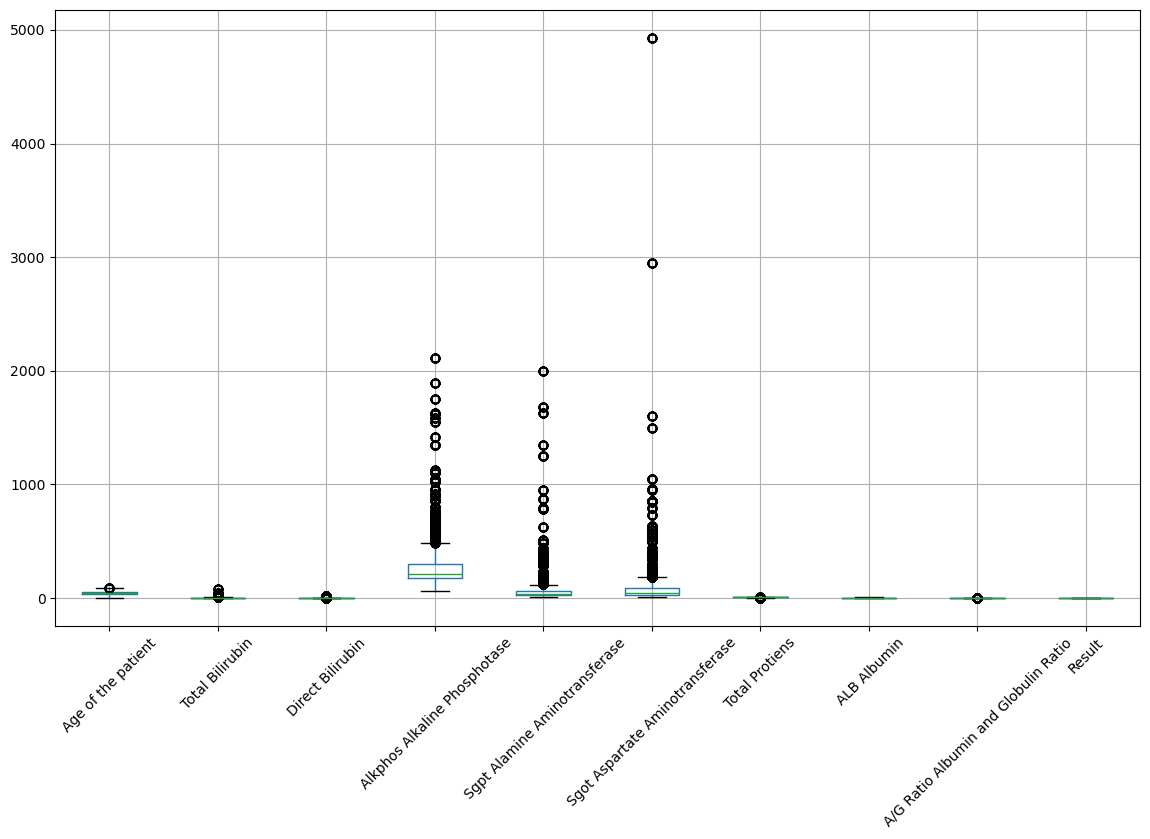

In [6]:
plt.figure(figsize=(14,8))
xl_df.boxplot()
plt.xticks(rotation=45)
plt.show()

### imputing missing values

In [7]:
xl_df.isna().sum() / len(xl_df)

Age of the patient                      0.000052
Gender of the patient                   0.041099
Total Bilirubin                         0.028759
Direct Bilirubin                        0.025299
 Alkphos Alkaline Phosphotase           0.035832
 Sgpt Alamine Aminotransferase          0.023699
Sgot Aspartate Aminotransferase         0.020291
Total Protiens                          0.019104
 ALB Albumin                            0.021324
A/G Ratio Albumin and Globulin Ratio    0.022511
Result                                  0.000000
dtype: float64

### label representation
- "1" likely represents a patient with liver disease (positive case).
- "2" likely represents a healthy patient (negative case).

In [8]:
# split features and label
X= xl_df.iloc[:,:-1]
y= xl_df.iloc[:,-1]

#split train and test set
X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=6)

In [9]:
cat_cols= X.select_dtypes(include='object').columns
numeric_cols= X.select_dtypes(exclude='object').columns

# preprocessing for numeric features 
numeric_preprocessor= Pipeline(steps= [
    ('imputer',SimpleImputer(strategy='mean')),        
    ('scaler', StandardScaler())
])

# preprocessing for categorical feature
categorical_preprocessor= Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False)), 
])

# combine both numeric and categorical transformer 
preprocessor = ColumnTransformer(transformers=[
    ('num-pipeline', numeric_preprocessor, numeric_cols),    
    ('cat-pipeline', categorical_preprocessor, cat_cols)],
                                 remainder='passthrough')

# create a pipeline for preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('model',LogisticRegression())
])

# encode label as [0,1] form [1,2]
label_encoder= LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)

pipeline.fit(X_train,y_train).score(X_train,y_train)

0.7187298309022847

- pipeline - works squentially (one after another)
- column transformer - works parallelly

In [10]:
X_train= preprocessor.fit_transform(X_train)
X_test= preprocessor.transform(X_test)

In [11]:
def show_scores(model, X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    train_preds= model.predict(X_train)
    test_preds= model.predict(X_test)
    print('Train accuracy',accuracy_score(y_train,train_preds))
    print('Test accuracy',accuracy_score(y_test,test_preds))
    print('Train classification \n\n',classification_report(y_train,train_preds))
    print('Test classification \n\n',classification_report(y_test,test_preds))
    

In [12]:
log_reg= LogisticRegression()
knn= KNeighborsClassifier()
gauss= GaussianNB()
tree_model= DecisionTreeClassifier()
rf_model= RandomForestClassifier()

for model in [log_reg, knn, gauss, tree_model, rf_model]:
    print('\n',model)
    show_scores(model, X_train,X_test,y_train,y_test)
    


 LogisticRegression()
Train accuracy 0.7187298309022847
Test accuracy 0.725090345895715
Train classification 

               precision    recall  f1-score   support

           0       0.74      0.93      0.83     11018
           1       0.54      0.19      0.28      4476

    accuracy                           0.72     15494
   macro avg       0.64      0.56      0.55     15494
weighted avg       0.68      0.72      0.67     15494

Test classification 

               precision    recall  f1-score   support

           0       0.75      0.93      0.83      2793
           1       0.52      0.19      0.27      1081

    accuracy                           0.73      3874
   macro avg       0.63      0.56      0.55      3874
weighted avg       0.68      0.73      0.68      3874


 KNeighborsClassifier()
Train accuracy 0.9213243836323738
Test accuracy 0.871708828084667
Train classification 

               precision    recall  f1-score   support

           0       0.94      0.95      0

In [13]:
test_model= RandomForestClassifier()
test_model.fit(X_train, y_train)
predictions = test_model.predict(X_test)

In [14]:
accuracy_score(y_test, predictions)

0.9925141972121838

In [15]:
print('accuracy: ', accuracy_score(y_test, predictions))
print('precision: ', precision_score(y_test, predictions))
print('recall: ', recall_score(y_test, predictions))

accuracy:  0.9925141972121838
precision:  0.9962264150943396
recall:  0.9768732654949122


In [16]:
recall_score(y_test, predictions)

0.9768732654949122

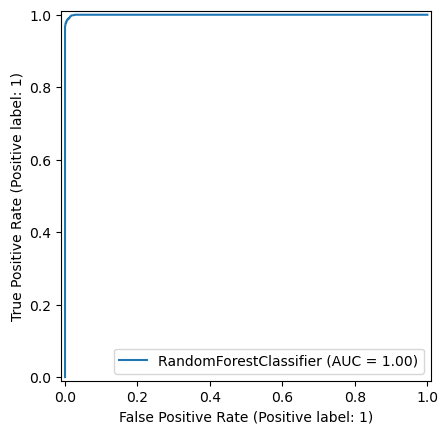

In [17]:
RocCurveDisplay.from_estimator(test_model, X_test, y_test)

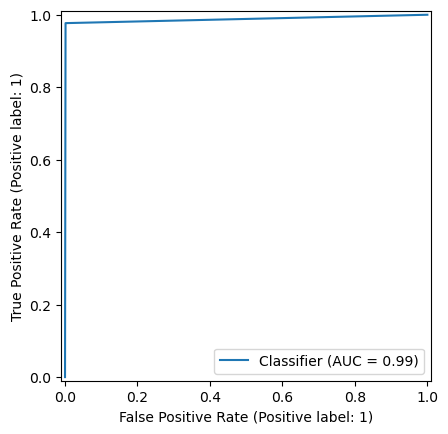

In [18]:
RocCurveDisplay.from_predictions(y_test,predictions)

In [19]:
confusion_matrix(y_test, predictions)

array([[2789,    4],
       [  25, 1056]], dtype=int64)

Summary: Out of 2793 type 1(positive for disease) cases which is sensitive, the model is able to predict 2790 cases as correct and misleading 3 cases with accuracy of 
0.99 % which is good.

In [20]:
from xgboost import XGBClassifier
xg_boost= XGBClassifier()
xg_boost.fit(X_train,y_train)
xg_pred= xg_boost.predict(X_test)

In [21]:
r2_score(y_test,xg_pred)

0.9781871753521507

In [22]:
print(classification_report(y_test, predictions))
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2793
           1       1.00      0.98      0.99      1081

    accuracy                           0.99      3874
   macro avg       0.99      0.99      0.99      3874
weighted avg       0.99      0.99      0.99      3874

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2793
           1       1.00      0.99      0.99      1081

    accuracy                           1.00      3874
   macro avg       1.00      0.99      0.99      3874
weighted avg       1.00      1.00      1.00      3874



In [23]:
print('accuracy: ', accuracy_score(y_test, predictions))
print('precision: ', precision_score(y_test, predictions))
print('recall: ', recall_score(y_test, predictions))
print('\n')
print('accuracy: ', accuracy_score(y_test, xg_pred))
print('precision: ', precision_score(y_test, xg_pred))
print('recall: ', recall_score(y_test, xg_pred))
print('\n')
print('with label ', log_loss(y_test, predictions ))
print('xg_boost with label', log_loss(y_test,xg_pred))

accuracy:  0.9925141972121838
precision:  0.9962264150943396
recall:  0.9768732654949122


accuracy:  0.995611770779556
precision:  0.996268656716418
recall:  0.9879740980573543


with label  0.2698156810233346
xg_boost with label 0.15816781301367902


In [24]:
print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, xg_pred))

[[2789    4]
 [  25 1056]]
[[2789    4]
 [  13 1068]]
